### Mancala Reinforcement Learning Algorithm

**things I need:**

- an environment (mancala board)
- a policy (epsilon greedy)
- a value function (value of each state)
- a model (predicts next state and reward)

**procedure:**

- make a q network
- make a history of all states
- calculate the reward
- every 4 steps update the q network


In [36]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List
from enum import Enum

In [37]:
class Activation(Enum):
    RELU = 0
    SIGMOID = 1

class QLayer():
    def __init__(self, input_size : int, output_size : int, activation : Activation):
        self.output_size = output_size
        self.input_size = input_size
        self.W = np.random.rand(input_size, output_size) - 1
        self.b = np.random.rand(output_size) - 1
        self.x = None
        self.z = None
        self.a = None
        self.activation = activation
    
    def forward(self, x) -> np.ndarray:
        self.x = x
        self.z = np.dot(x, self.W) + self.b
        self.a = self.activate(self.z)
        return self.a

    def activate(self, z : np.ndarray) -> np.ndarray:
        if (self.activation == Activation.RELU):
            return np.maximum(0,z)
        elif (self.activation == Activation.SIGMOID):
            return 1 / (1 + np.exp(-z))

In [38]:

class QNetwork():
    def __init__(self, layers : List[QLayer], learning_rate: float):
        self.layers = layers
        self.learning_rate = learning_rate
    
    def forward(self, a : np.ndarray ):
        '''returns the output from the forward propagation as a ndarray of size shapes[-1][1]'''
        assert len(a) == self.layers[0].input_size
        for i in range(len(self.layers)):
            a = self.layers[i].forward(a)
        return a
    
    def backward(self, y_true: np.ndarray, y_pred: np.ndarray):
        # loop through the layers backwards and apply the correct gradients to weights along the way
        # calculate gradient for the cost
        gradient : np.ndarray = (y_pred - y_true) / y_pred.size
        for layer in reversed(self.layers):
            gradient = self.gradient(gradient, layer)

    def gradient(self, gradient: np.ndarray, layer: QLayer) -> np.ndarray:
        if (layer.activation == Activation.RELU):
            gradient[layer.z <= 0] = 0
        elif layer.activation == Activation.SIGMOID:
            gradient *= layer.a * (1-layer.a)
        
        layer.W -= self.learning_rate * np.outer(layer.x, gradient)
        layer.b -= self.learning_rate * gradient

        return np.dot(layer.W, gradient)

In [39]:
net = QNetwork([QLayer(14,64,Activation.RELU),
                   QLayer(64,64,Activation.RELU),
                   QLayer(64,6,Activation.SIGMOID)],
                   learning_rate=0.01)

In [40]:
class Agent():
    def __init__(self):
        self.q_a = QNetwork([(14,64), (64,64), (64,6)], 
                            [Activation.RELU, Activation.RELU, Activation.SIGMOID])
        self.q_a = QNetwork([(14,64), (64,64), (64,6)], 
                            [Activation.RELU, Activation.RELU, Activation.SIGMOID])

    def update(self):
        # pass in the data and update the networks
        return

In [62]:
class MancalaBoard():
    def __init__(self):
        self.reset()

    def reset(self):
        self.board : np.array = np.array([4,4,4,4,4,4,0,4,4,4,4,4,4,0])
        self.player : int = 0
        self.turn : int = 0
        self.last_action : int = 0
        self.last_action_taken_by : int = 0
        self.gameOver : bool = False

    def __str__(self):
        game = f"Player: {self.last_action_taken_by}, Turn: {self.turn}, Action: {self.last_action}\n\n"
        game += f"Pieces: {np.sum(self.board)}\n"
        game += "________________\n"
        game += f"|      {self.board[13]}      |\n"
        for i in range(0, 6):
            game += f"|  {self.board[i]}   |   {self.board[12 - i]}  |\n"
        game += f"|      {self.board[6]}      |\n"
        game += "________________\n"
        return game

    def move(self, action : int):
        self.turn+=1
        self.last_action = action
        self.last_action_taken_by = self.player
        pieces : int = self.board[action]
        goal_i : int = 6 if self.player == 0 else 13
        skip : int = 13 if self.player == 0 else 6
        board_copy = self.board.copy()
        # move all the pieces around the board
        self.board[action] = 0
        dest_i = (action) % 14
        for i in range(pieces):
            dest_i = (dest_i + 1) % 14
            # don't put in your opponent's goal
            if (dest_i == skip):
                dest_i = (dest_i + 1) % 14
            self.board[dest_i] += 1
        # if you landed on an empty square on your side, move all pieces to your goal
        if (self.board[dest_i] == 1 and self.board[12 - dest_i] > 0 and ((dest_i < 6 and self.player == 0) or (dest_i >= 7 and dest_i < 13 and self.player == 1))):
            self.board[goal_i] += self.board[dest_i] + self.board[12-dest_i]
            self.board[dest_i] = 0
            self.board[12-dest_i] = 0
        # if you land on your goal, go again
        if (dest_i != goal_i): 
            self.player = 0 if self.player == 1 else 1
        ### game over cases ###
        # one side becomes empty
        if (np.sum(self.board[0:6]) == 0 ):
            for i in range(7,13):
                self.board[13] += self.board[i]
                self.board[i] = 0
            self.gameOver = True
        elif (np.sum(self.board[7:13]) == 0):
            for i in range(0, 6):
                self.board[6] += self.board[i]
                self.board[i] = 0
            self.gameOver = True
        # return the experience data
        return self.board.copy(), self._getReward(self.player, board_copy), self.gameOver
        

    def _getReward(self, player : int, old_board : np.ndarray):
        your_score : int = self.board[13] if player == 1 else self.board[6]
        their_score : int = self.board[6] if player == 0 else self.board[13]
        if (self.gameOver):
            return 5 if your_score > their_score else -5
        else:
            your_old_score : int = old_board[13] if player == 1 else old_board[6]
            their_old_score : int = old_board[6] if player == 0 else old_board[13]
            return (your_score - your_old_score) - 0.5 * (their_score - their_old_score)

        

        

In [65]:
iter = 100000
epsilon = 1.0
epsilon_decay_rate = 0.999
min_epsilon = 0.01
discount_factor = 0.99
q_net = QNetwork([QLayer(14,64,Activation.RELU),
                   QLayer(64,64,Activation.RELU),
                   QLayer(64,6,Activation.SIGMOID)],
                   learning_rate=0.01)

iter: 0, cost: 0.06976499580103464
iter: 1000, cost: 0.05099050004596209
iter: 2000, cost: 0.050867364395969034
iter: 3000, cost: 0.04387722310850644
iter: 4000, cost: 2.0336592005303284
iter: 5000, cost: 1.8991759599737765
iter: 6000, cost: 0.08036922077082681
iter: 7000, cost: 2.289779095953117
iter: 8000, cost: 0.05245847198924803
iter: 9000, cost: 0.06786898668588531


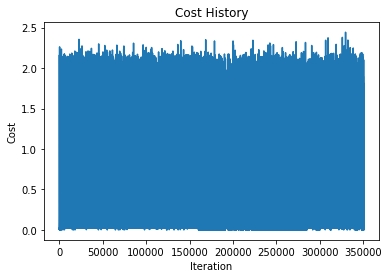

In [66]:
env = MancalaBoard()
cost_hist = []
for i in range(iter):
    env.reset()
    game_over = False
    ave_cost = 0.0
    while not game_over:
        state = env.board
    # choose an action with epsilon greedy
        if (env.player == 0):
            rand_e = np.random.rand()
            q_pred = q_net.forward(state)
            if (rand_e < epsilon):
                valid_indices = np.where(state[:6] > 0)[0]
                action = np.random.choice(valid_indices)
            else:
                action = np.argmax(np.where(state[:6] > 0, q_pred, 0))
            # get the new state from the action
            new_state, reward, game_over = env.move(action)
            q_target_max = reward + discount_factor * np.max(q_net.forward(new_state))
            q_target = q_pred.copy()
            q_target[action] = q_target_max
            cost = np.sum(np.square(q_pred - q_target)) / (2*q_pred.size)
            ave_cost += cost
            # if (cost > 200):
            #     print(f'reward: {reward}')
            #     print(f'q_target_max:  {q_target_max}')
            #     print(f'q_pred:  {np.max(q_pred)}')
            #     print(env)
            # backpropagate
            q_net.backward(q_target, q_pred)
        else:
            valid = False
            while not valid:
                action = np.random.randint(7,13)
                valid = state[action] > 0
            new_state, reward, game_over = env.move(action)
        epsilon = max(min_epsilon, epsilon * epsilon_decay_rate)
        cost_hist.append(ave_cost.mean())

    # iteration over
    # if (i % 10 == 0):
    if (i % 1000 == 0):
        print(f'iter: {i}, cost: {ave_cost}')

    # plot cost_hist as a line chart
plt.plot(cost_hist)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost History')
plt.show()


    


In [24]:
print(epsilon)

0.01


In [157]:
class Simulation():
    def __init__(self):
        self.board = MancalaBoard()
        self.player1 = QNetwork()
        self.player2 = QNetwork()
